In [22]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from zipfile import ZipFile
import warnings

# Suppress all warnings
warnings.filterwarnings("ignore")

In [23]:
df = pd.read_csv('selected_factor_and_return.csv')
df.set_index(['date'], inplace=True)

if "Unnamed: 0" in df.columns:
  df.drop("Unnamed: 0", axis=1, inplace=True)

df.head()


,Ticker,Size,Liquidity,cpv_1mo,mr_1yr,mr_1w,daily_return
date,,,,,,,
2005-03-02,4151.T,0.603338,-0.370407,NaN,NaN,-1.381918,-0.007344
2005-03-03,4151.T,0.603338,-0.370407,0.426358,NaN,-0.462423,0.016029
2005-03-04,4151.T,0.603338,-0.370407,-1.005234,NaN,-1.477961,-0.001213
2005-03-07,4151.T,0.603338,-0.370407,-0.731422,NaN,-0.398283,0.001215
2005-03-08,4151.T,0.603338,-0.370407,-1.081762,NaN,-1.433256,0.002427


In [24]:
df.tail()

,Ticker,Size,Liquidity,cpv_1mo,mr_1yr,mr_1w,daily_return
date,,,,,,,
2024-02-22,4887.T,0.052614,0.312916,-0.967226,-1.227663,1.173214,-0.003213
2024-02-26,4887.T,0.052614,0.312916,-1.061441,-1.209116,-0.017219,-0.012723
2024-02-27,4887.T,0.052614,0.312916,-1.163607,-1.202994,-0.882076,-0.010309
2024-02-28,4887.T,0.052614,0.312916,-1.065248,-1.200425,1.144204,-0.001042
2024-02-29,4887.T,0.052614,0.312916,-1.059960,-1.204539,1.191659,-0.001738


In [25]:
stocks = df.groupby('Ticker')
stocks.get_group('4151.T')


,Ticker,Size,Liquidity,cpv_1mo,mr_1yr,mr_1w,daily_return
date,,,,,,,
2005-03-02,4151.T,0.603338,-0.370407,NaN,NaN,-1.381918,-0.007344
2005-03-03,4151.T,0.603338,-0.370407,0.426358,NaN,-0.462423,0.016029
2005-03-04,4151.T,0.603338,-0.370407,-1.005234,NaN,-1.477961,-0.001213
2005-03-07,4151.T,0.603338,-0.370407,-0.731422,NaN,-0.398283,0.001215
2005-03-08,4151.T,0.603338,-0.370407,-1.081762,NaN,-1.433256,0.002427
...,...,...,...,...,...,...,...
2024-02-22,4151.T,0.966493,-0.491249,-1.148382,0.410803,-1.428353,-0.001910
2024-02-26,4151.T,0.966493,-0.491249,-1.182013,0.432673,-0.596683,0.014962
2024-02-27,4151.T,0.966493,-0.491249,-1.186365,0.359380,-0.191890,0.010970


In [26]:
# get list of features and target column
features_cols = df.columns[1:-1]
target_col = df.columns[-1]

In [27]:
target = df[target_col]
has_nan = target.isnull().values.any()
print("Contains NaN:", has_nan)

has_inf = target.isin([np.inf, -np.inf]).values.any()
print("Contains infinite values:", has_inf)

Contains NaN: False
Contains infinite values: False


In [28]:
mean_ret = target.mean()
df[target_col].fillna(mean_ret, inplace=True)
has_nan = target.isnull().values.any()
print("Contains NaN:", has_nan)

Contains NaN: False


In [29]:
# # scale ret by 100 for better precision
# df[target_col] = df[target_col] * 100 
# df

In [30]:
train_end = df.index.unique()[int(len(df.index.unique()) * 0.8)]
train_end

'2020-04-27'

In [31]:
val_end = df.index.unique()[int(len(df.index.unique()) * 0.9)]
val_end

'2022-03-31'

In [32]:
train_df  = df[df.index <= train_end].copy()
valid_df  = df[(df.index > train_end) & (df.index <= val_end)].copy()
test_df   = df[df.index > val_end].copy()

test_df.tail()

,Ticker,Size,Liquidity,cpv_1mo,mr_1yr,mr_1w,daily_return
date,,,,,,,
2024-02-22,4887.T,0.052614,0.312916,-0.967226,-1.227663,1.173214,-0.003213
2024-02-26,4887.T,0.052614,0.312916,-1.061441,-1.209116,-0.017219,-0.012723
2024-02-27,4887.T,0.052614,0.312916,-1.163607,-1.202994,-0.882076,-0.010309
2024-02-28,4887.T,0.052614,0.312916,-1.065248,-1.200425,1.144204,-0.001042
2024-02-29,4887.T,0.052614,0.312916,-1.059960,-1.204539,1.191659,-0.001738


In [33]:
valid_date = valid_df.index
valid_ticker = valid_df.Ticker
valid_date
# valid_ticker

Index(['2020-04-28', '2020-04-30', '2020-05-01', '2020-05-07', '2020-05-08',
       '2020-05-11', '2020-05-12', '2020-05-13', '2020-05-14', '2020-05-15',
       ...
       '2022-03-17', '2022-03-18', '2022-03-22', '2022-03-23', '2022-03-24',
       '2022-03-25', '2022-03-28', '2022-03-29', '2022-03-30', '2022-03-31'],
      dtype='object', name='date', length=16533)

In [34]:
test_df

test_date = test_df.index
test_ticker = test_df.Ticker
test_date
test_ticker

date
2022-04-01    4151.T
2022-04-04    4151.T
2022-04-05    4151.T
2022-04-06    4151.T
2022-04-07    4151.T
               ...  
2024-02-22    4887.T
2024-02-26    4887.T
2024-02-27    4887.T
2024-02-28    4887.T
2024-02-29    4887.T
Name: Ticker, Length: 17429, dtype: object

In [35]:
train_df.drop(columns=['Ticker'], inplace=True)
train_df.tail()
train_df.isnull().sum()

Size               0
Liquidity          0
cpv_1mo         3244
mr_1yr          5064
mr_1w              0
daily_return       0
dtype: int64

In [36]:

for col in train_df.columns:
  train_df[col].fillna(0, inplace=True)
train_df.isnull().sum()

Size            0
Liquidity       0
cpv_1mo         0
mr_1yr          0
mr_1w           0
daily_return    0
dtype: int64

In [37]:
if 'Ticker' in test_df.columns:
  test_df.drop(columns=['Ticker'], inplace=True)

for col in test_df.columns:
  test_df[col].fillna(0, inplace=True)
test_df.isnull().sum()

Size            0
Liquidity       0
cpv_1mo         0
mr_1yr          0
mr_1w           0
daily_return    0
dtype: int64

In [38]:
if 'Ticker' in valid_df.columns:
  valid_df.drop(columns=['Ticker'], inplace=True)

for col in valid_df.columns:
  valid_df[col].fillna(valid_df[col].mean(), inplace=True)
valid_df.isnull().sum()

Size            0
Liquidity       0
cpv_1mo         0
mr_1yr          0
mr_1w           0
daily_return    0
dtype: int64

In [39]:
target_col

'daily_return'

In [40]:

y_train = train_df[target_col].copy()
X_train = train_df.drop([target_col], 1)

y_valid = valid_df[target_col].copy()
X_valid = valid_df.drop([target_col], 1)

y_test  = test_df[target_col].copy()
X_test  = test_df.drop([target_col], 1)

X_train.info()


<class 'pandas.core.frame.DataFrame'>
Index: 116742 entries, 2005-03-02 to 2020-04-27
Data columns (total 5 columns):
 #   Column     Non-Null Count   Dtype  
---  ------     --------------   -----  
 0   Size       116742 non-null  float64
 1   Liquidity  116742 non-null  float64
 2   cpv_1mo    116742 non-null  float64
 3   mr_1yr     116742 non-null  float64
 4   mr_1w      116742 non-null  float64
dtypes: float64(5)
memory usage: 5.3+ MB


The stock returns in the following two days are split to two target variables.

In [41]:
import xgboost as xgb
from xgboost import plot_importance, plot_tree
from sklearn.model_selection import train_test_split, GridSearchCV


In [42]:
%%time

parameters = {
    'n_estimators': [100, 200, 300, 400],
    'learning_rate': [0.001, 0.005, 0.01, 0.05],
    'max_depth': [8, 10, 12, 15],
    'gamma': [0.001, 0.005, 0.01, 0.02],
    'random_state': [42]
}

eval_set = [(X_train, y_train), (X_valid, y_valid)]
model = xgb.XGBRegressor(eval_set=eval_set, objective='reg:squarederror', verbose=False)
clf = GridSearchCV(model, parameters)

clf.fit(X_train, y_train)

print(f'Best params: {clf.best_params_}')
print(f'Best validation score = {clf.best_score_}')

KeyboardInterrupt: 

In [ ]:
%%time

model = xgb.XGBRegressor(**clf.best_params_, objective='reg:squarederror')
model.fit(X_train, y_train, eval_set=eval_set, verbose=False)

CPU times: user 24.9 s, sys: 1.92 s, total: 26.8 s
Wall time: 4.09 s


XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=0.001, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.001, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=8, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=400, n_jobs=None,
             num_parallel_tree=None, random_state=42, ...)

<Axes: title={'center': 'Feature importance'}, xlabel='F score', ylabel='Features'>

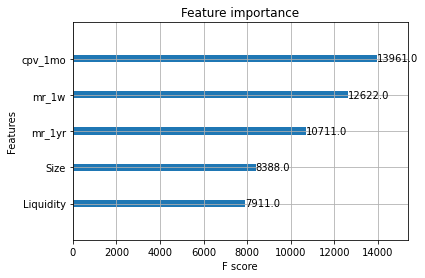

In [ ]:
plot_importance(model)


In [ ]:
y_pred = model.predict(X_test)
print(f'y_true = {np.array(y_test)}')
print(f'y_pred = {y_pred}')

y_true = [-0.00151045 -0.0060514   0.00456614 ... -0.01030932 -0.00104161
 -0.001738  ]
y_pred = [0.00044661 0.00045588 0.00083247 ... 0.00114235 0.0004246  0.00039341]


In [ ]:
y_pred

array([0.00044661, 0.00045588, 0.00083247, ..., 0.00114235, 0.0004246 ,
       0.00039341], dtype=float32)

In [ ]:
from sklearn.metrics import mean_squared_error

print(f'mean_squared_error = {mean_squared_error(y_test, y_pred)}')


mean_squared_error = 0.00032614282438875547


In [ ]:
pred_date_df = pd.DataFrame(test_date.to_list()).rename(columns={0: 'date'})
pred_ticker_df = pd.DataFrame(test_ticker).reset_index(drop=True)
y_pred_df = pd.DataFrame(y_pred).rename(columns={0: 'prediction'})

In [ ]:
pred_df = pd.concat([pred_date_df, pred_ticker_df, y_pred_df], axis=1)
pred_df

,date,Ticker,prediction
0,2021-04-14,4151.T,0.000447
1,2021-04-15,4151.T,0.000456
2,2021-04-16,4151.T,0.000832
3,2021-04-19,4151.T,0.000599
4,2021-04-20,4151.T,0.000246
...,...,...,...
25767,2024-02-22,4887.T,0.000486
25768,2024-02-26,4887.T,0.000416
25769,2024-02-27,4887.T,0.001142
25770,2024-02-28,4887.T,0.000425


In [ ]:
excel_file_path = "xgboost_pred-8-1-1.xlsx"

pred_df.to_excel(excel_file_path, index=False)

In [ ]:
valid_y_pred = model.predict(X_valid)
print(f'y_true = {np.array(y_valid)}')
print(f'y_pred = {valid_y_pred}')

y_true = [ 0.02513474  0.02583192 -0.00682917 ... -0.0189243  -0.01319797
 -0.00925926]
y_pred = [0.0005894  0.00042632 0.00042632 ... 0.00038742 0.00041739 0.00041579]


In [ ]:
valid_pred_date_df = pd.DataFrame(valid_date.to_list()).rename(columns={0: 'date'})
valid_pred_ticker_df = pd.DataFrame(valid_ticker).reset_index(drop=True)
valid_y_pred_df = pd.DataFrame(valid_y_pred).rename(columns={0: 'prediction'})

In [ ]:
valid_pred_df = pd.concat([valid_pred_date_df, valid_pred_ticker_df, valid_y_pred_df], axis=1)
valid_pred_df

,date,Ticker,prediction
0,2018-06-01,4151.T,0.000589
1,2018-06-04,4151.T,0.000426
2,2018-06-05,4151.T,0.000426
3,2018-06-06,4151.T,0.000419
4,2018-06-07,4151.T,0.000414
...,...,...,...
24635,2021-04-07,4587.T,0.000464
24636,2021-04-08,4587.T,0.000464
24637,2021-04-09,4587.T,0.000387
24638,2021-04-12,4587.T,0.000417


In [ ]:
excel_file_path = "xgboost_validation_pred-8-1-1.xlsx"

valid_pred_df.to_excel(excel_file_path, index=False)